In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
# import the KMeans clustering model from scikit-learn
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.base.datetools import dates_from_str
import warnings
%matplotlib inline

## VAR

select some features

**TODO:TODO:TODO:SOME VARIABLES ARE NOT VARIABLES AT ALL: THEY ARE CONSTANT → THEY SHOULD BE REMOVED**

In [2]:
ts=pd.read_csv('data/china.csv')
ts.set_index('Year',inplace=True)
# ts.drop(columns=['Temperature (annual mean)','Population density (people per sq. km of land area)'],inplace=True)
ts.drop(columns=['Water demand'],inplace=True)
ts.interpolate(method='linear', order=2, axis=0,inplace=True)
ts

,Temperature,Precipitation,Population density,GDP per capita,Water stress
Year,,,,,
2004,7.61,573.50,137.518959,1508.668098,40.328072
2005,7.30,596.21,138.330136,1753.417829,40.730246
2006,7.82,575.13,139.104693,2099.229435,41.132421
2007,8.02,579.83,139.833098,2693.970063,41.534595
2008,7.47,619.24,140.551423,3468.304602,41.974262
2009,7.64,554.26,141.252234,3832.236432,42.413929
2010,7.40,639.78,141.936072,4550.453108,42.853596
2011,7.22,540.06,142.713813,5614.352135,43.293262
2012,6.94,640.01,143.685196,6300.615118,43.732929


### Plot the time series:

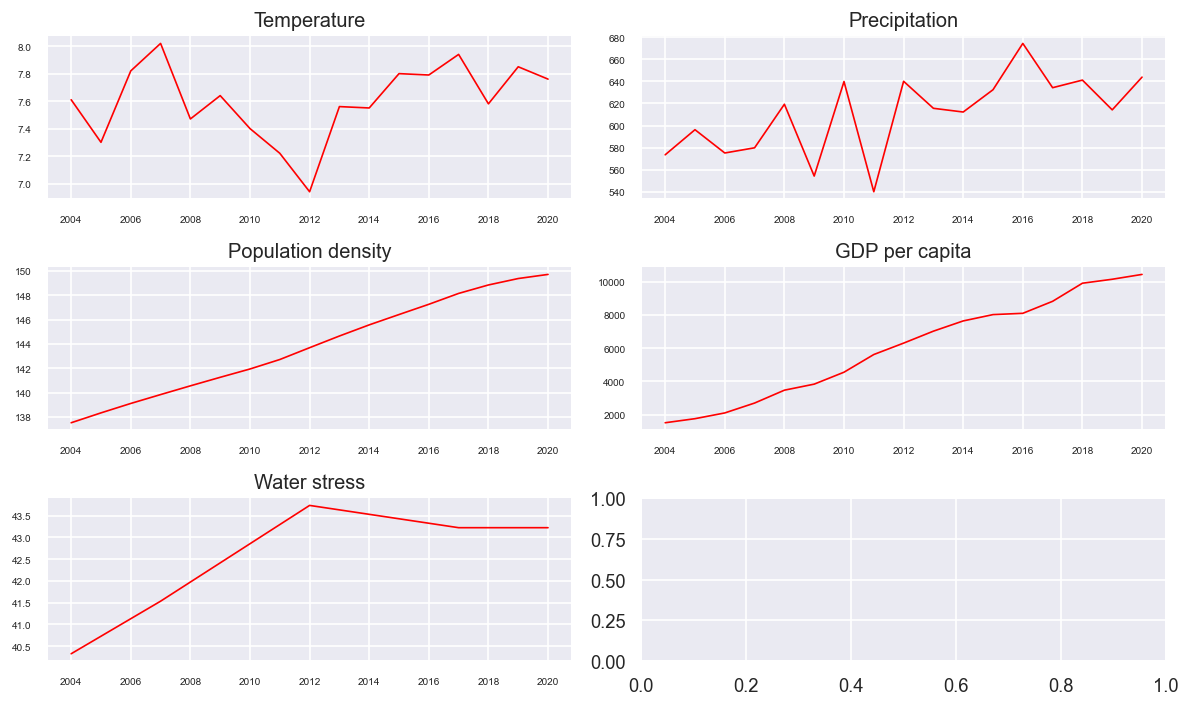

In [3]:
def plot_vars(ts):
  fig, axes = plt.subplots(nrows=int(len(ts.columns)/2)+1, ncols=2, dpi=120, figsize=(10,6))
  for i, ax in enumerate(axes.flatten()):
      if i > len(ts.columns)-1:
        break
      data = ts[ts.columns[i]]
      ax.plot(data, color='red', linewidth=1)
      # Decorations
      ax.set_title(ts.columns[i])
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

  plt.tight_layout();

plot_vars(ts)

## Train/Validation split

In [398]:
nobs = 1
ts_train, ts_test = ts[0:-nobs], ts[-nobs:]
# Check size
print(ts_train.shape)  # (119, 8)
print(ts_test.shape)  # (4, 8)
ts_train.index

(16, 5)
(1, 5)


Int64Index([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017, 2018, 2019],
           dtype='int64', name='Year')

## Stationarity check

In [399]:
def adfuller_test(df, signif=0.05, verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    count=0
    for name, series in df.iteritems():
        r = adfuller(series, autolag='AIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue'] 
        def adjust(val, length= 6): return str(val).ljust(length)

        # Print Summary
        # print(f' Significance Level    = {signif}')
        # print(f' Test Statistic        = {output["test_statistic"]}')
        # print(f' No. Lags Chosen       = {output["n_lags"]}')

        # for key,val in r[4].items():
        #     print(f' Critical value {adjust(key)} = {round(val, 3)}')
        if p_value > signif:
            print(f'    ADF "{name}"', "\n   ", '-'*47)
            # print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")  
            count+=1
        # else:
        #     print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        #     print(f" => Series is Stationary.")
    print(count)
    return count

    ADF "Temperature" 
    -----------------------------------------------
 => P-Value = 0.8668. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    ADF "Precipitation" 
    -----------------------------------------------
 => P-Value = 0.6213. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    ADF "Population density" 
    -----------------------------------------------
 => P-Value = 0.9631. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    ADF "GDP per capita" 
    -----------------------------------------------
 => P-Value = 0.861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    ADF "Water stress" 
    -----------------------------------------------
 => P-Value = 0.1584. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
5
    ADF "Water stress" 
    -----------------------------------------------
 => P-Value = 0.7322. Weak evidence to reject the 

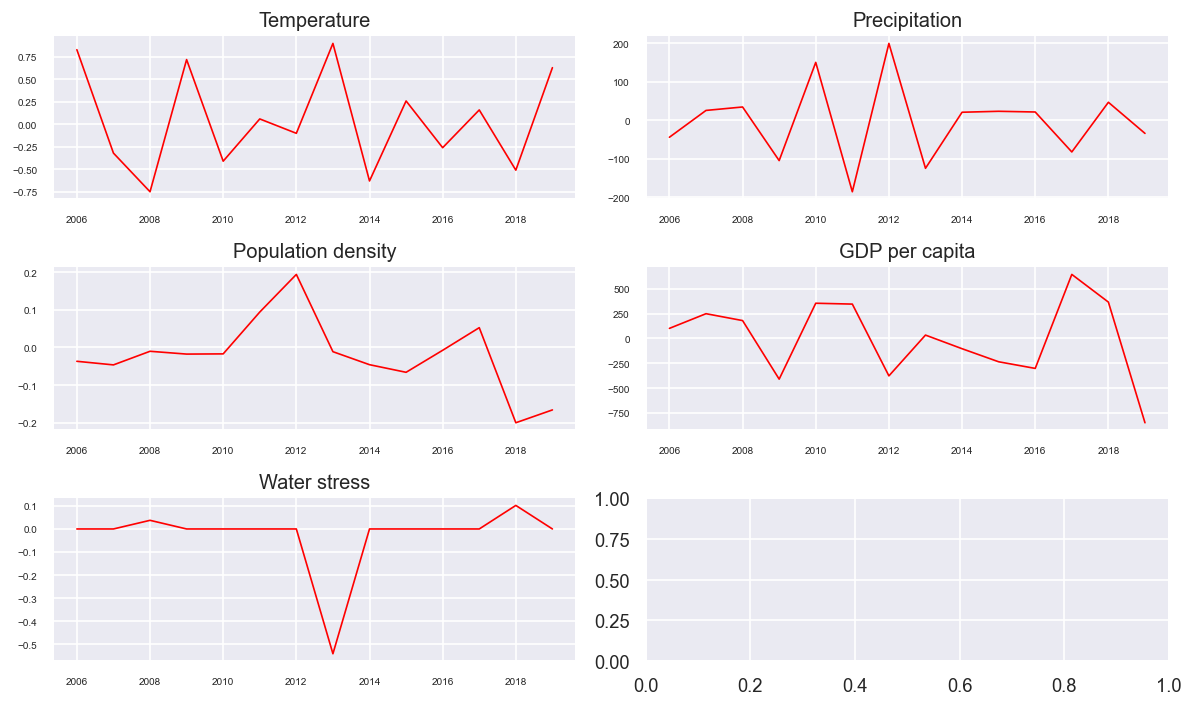

In [400]:
def get_diff(ts,order=1):
     tsdiff=ts
     for i in range(1,order+1,1):
          nonStationaryCount=adfuller_test(tsdiff)    
          if nonStationaryCount > 0:
               tsdiff= tsdiff.diff().dropna()
          else:
               tsdiff= tsdiff
     plot_vars(tsdiff)
     return tsdiff

# 3 order difference
ts_train_d2=get_diff(ts_train,2)

## Granger causality 

,Temperature_x,Precipitation_x,Population density_x,GDP per capita_x,Water stress_x
Temperature_y,1.0000,0.1037,0.3185,0.0887,0.6496
Precipitation_y,0.9146,1.0000,0.7372,0.2956,0.0589
Population density_y,0.7259,0.7667,1.0000,0.5912,0.8814
GDP per capita_y,0.3073,0.9615,0.2088,1.0000,0.8654
Water stress_y,0.8914,0.0061,0.0038,0.0380,1.0000


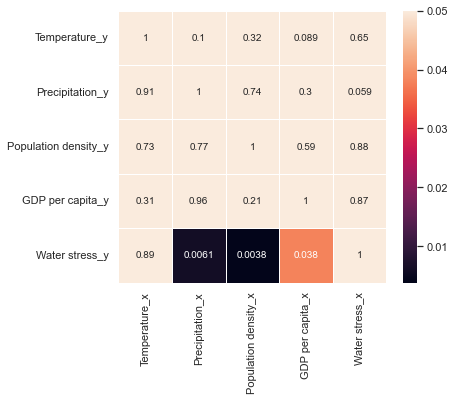

In [401]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=1
test = 'ssr_chi2test'
def grangers_causation_matrix(data, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    variables=data.columns
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_result=grangers_causation_matrix(ts_train_d2)
plt.figure(figsize=(6,5))
sns.heatmap(granger_result,annot=True, linewidths=.5, vmax=.05)
granger_result

## Cointegration test


In [402]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(ts)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Temperature ::  155.19    > 60.0627   =>   True
Precipitation ::  64.48     > 40.1749   =>   True
Population density ::  26.1      > 24.2761   =>   True
GDP per capita ::  4.09      > 12.3212   =>   False
Water stress ::  0.89      > 4.1296    =>   False


## Fit the model

select best lag value

In [403]:
model = VAR(ts_train_d2)
# for i in range(1,2,1):
#     fit = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', fit.aic)
#     print('BIC : ', fit.bic)
#     print('FPE : ', fit.fpe)
#     print('HQIC: ', fit.hqic, '\n')

c:\Users\Nyx\mda_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [404]:
p=1
fit = model.fit(p)
fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Jun, 2022
Time:                     01:43:06
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    8.89091
Nobs:                     13.0000    HQIC:                   7.31921
Log likelihood:          -111.548    FPE:                    2876.83
AIC:                      7.58718    Det(Omega_mle):         431.383
--------------------------------------------------------------------
Results for equation Temperature
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.021471         0.133374            0.161           0.872
L1.Temperature               -0.493990         0.348961           -1.416           0.157
L1.Precipitation      

autocorrelation plots do not exceed the cutoffs

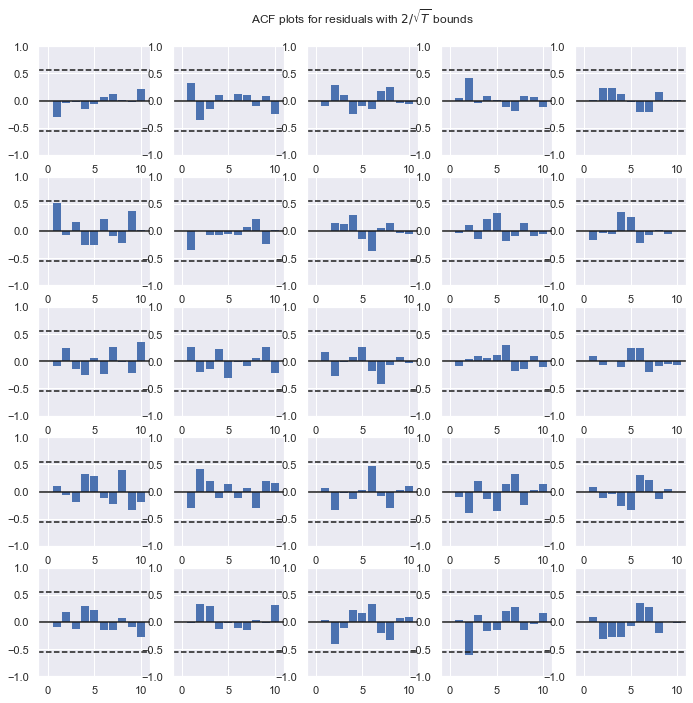

In [405]:
# fit.plot();
fit.plot_acorr();

## serial correlation check

2.37 Temperature
2.63 Precipitation
1.63 Population density
2.04 GDP per capita
1.46 Water stress


<BarContainer object of 5 artists>

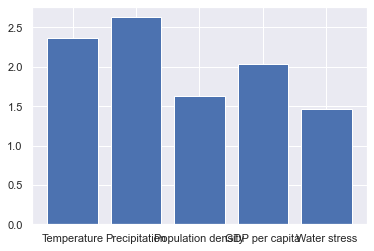

In [406]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fit.resid)
for col, val in zip(ts_train_d2.columns, out):
    print(round(val, 2),col)
plt.bar(ts_train_d2.columns,[round(val,2) for col, val in zip(ts_train_d2.columns, out)])

## Forecast

1


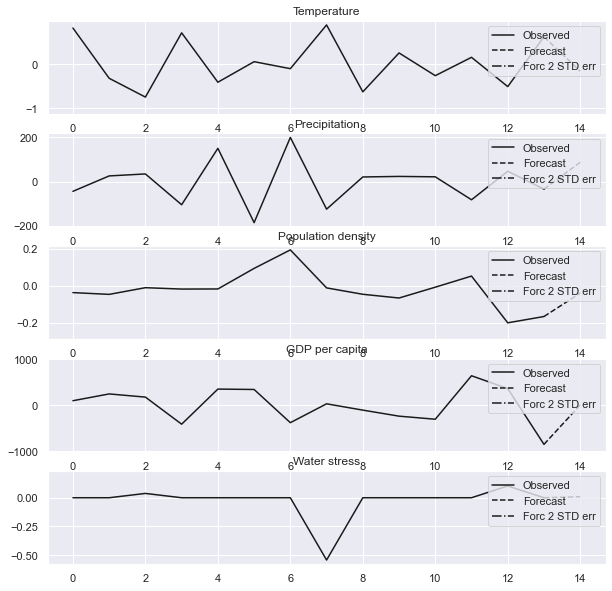

In [421]:
def forecast(fit,steps):
    # Get the lag order
    lag_order = p
    print(lag_order)

    # Input data for forecasting
    forecast_input = ts_train_d2.values[-lag_order:]
    forecast_input
    # setting indices
    idxf=ts_train_d2.index.values[-lag_order:][0]
    steps=steps

    # Forecast
    fc = fit.forecast(y=forecast_input, steps=steps)
    # ts_forecast=pd.DataFrame(fc, index=np.linspace(start=idxf+5,stop=idxf+nobs*5,num=nobs).tolist(), columns=ts.columns + '_diff')
    ts_forecast=pd.DataFrame(fc, index=np.linspace(start=idxf+1,stop=idxf+steps*1,num=steps).tolist(), columns=ts.columns + '_d2')


    fit.plot_forecast(nobs);
    return ts_forecast

steps=10
ts_forecast=forecast(fit,10)

## Invert differencing

In [422]:
def invert_transformation(ts_train, ts_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = ts_forecast.copy()
    columns = ts_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_d1'] = (ts_train[col].iloc[-1]-ts_train[col].iloc[-2]) + df_fc[str(col)+'_d2'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = ts_train[col].iloc[-1] + df_fc[str(col)+'_d1'].cumsum()
        # df_fc[str(col)+'_forecast'] = ts_train[col].iloc[-1] + df_fc[str(col)+'_d1'].cumsum()
    # return df_fc
    return df_fc.loc[:, (~(df_fc.columns.str.contains('_d2|_d1')))] 

ts_results = invert_transformation(ts_train, ts_forecast, second_diff=True) 
ts_results

,Temperature,Precipitation,Population density,GDP per capita,Water stress
2020.0,7.962271,674.590551,149.856923,10390.626955,43.230529
2021.0,8.244528,656.855044,150.301636,10627.461997,43.160175
2022.0,8.311910,706.906365,150.730856,10786.149690,43.140846
2023.0,8.619493,711.568813,151.141993,10948.337912,43.030504
2024.0,8.730645,751.895069,151.534027,11115.555676,42.917661
2025.0,8.984117,761.724250,151.908192,11237.964000,42.752496
2026.0,9.137328,802.207842,152.268632,11360.297099,42.570840
2027.0,9.381456,816.168270,152.609704,11468.913584,42.331709
2028.0,9.541145,853.244771,152.935766,11558.321178,42.079510
2029.0,9.781935,872.983878,153.244761,11633.064187,41.774718


## Compare forecast with test

In [423]:
ts_final=pd.concat([ts_train,ts_results])
ts_final

,Temperature,Precipitation,Population density,GDP per capita,Water stress
2004.0,7.610000,573.500000,137.518959,1508.668098,40.328072
2005.0,7.300000,596.210000,138.330136,1753.417829,40.730246
2006.0,7.820000,575.130000,139.104693,2099.229435,41.132421
2007.0,8.020000,579.830000,139.833098,2693.970063,41.534595
2008.0,7.470000,619.240000,140.551423,3468.304602,41.974262
2009.0,7.640000,554.260000,141.252234,3832.236432,42.413929
2010.0,7.400000,639.780000,141.936072,4550.453108,42.853596
2011.0,7.220000,540.060000,142.713813,5614.352135,43.293262
2012.0,6.940000,640.010000,143.685196,6300.615118,43.732929
2013.0,7.560000,615.570000,144.645433,7020.338485,43.630681


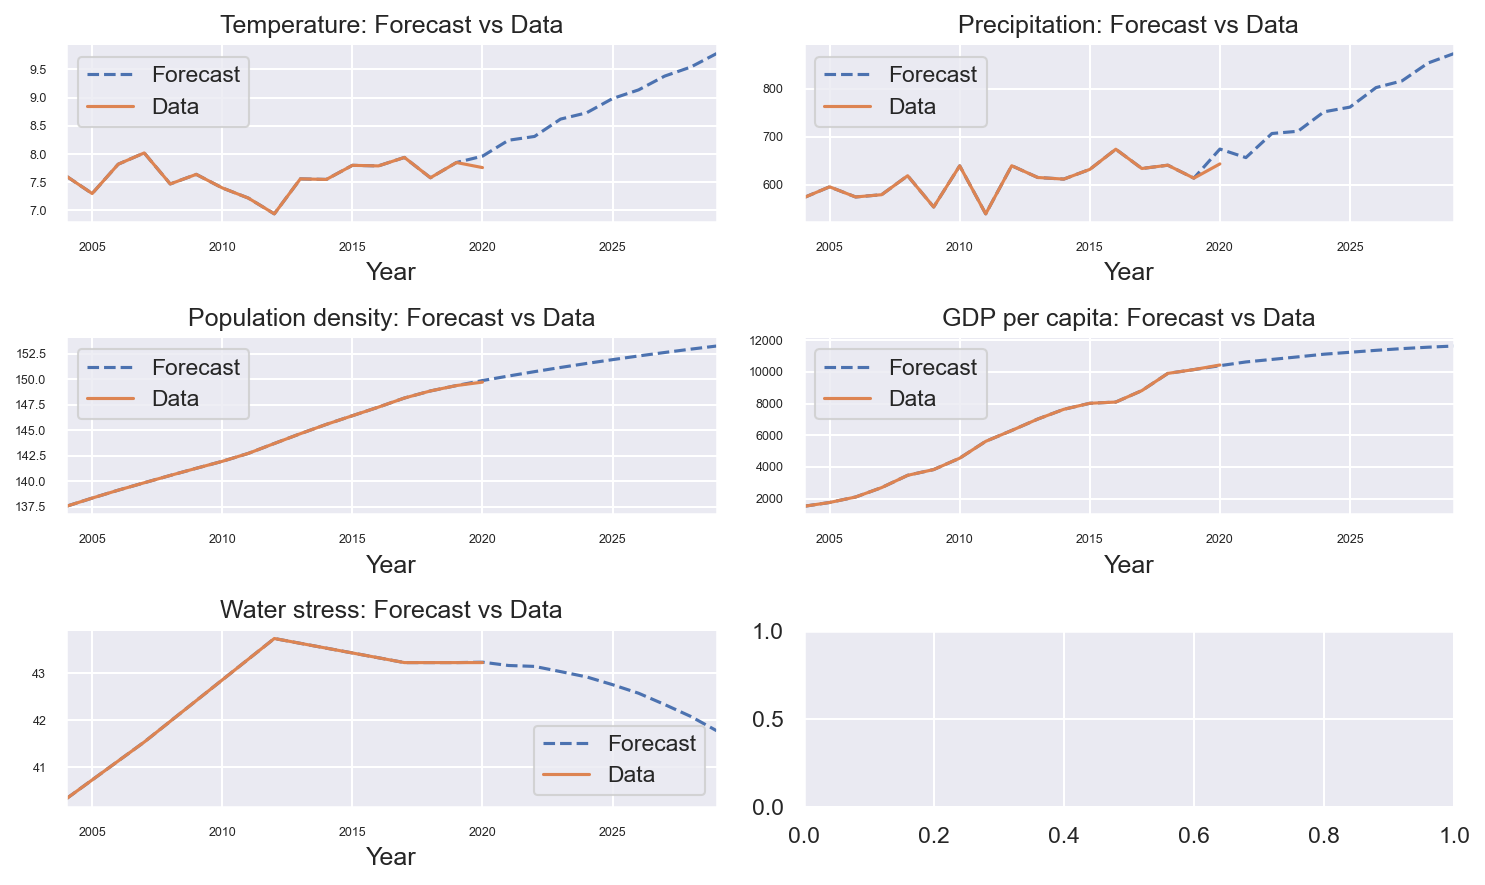

In [424]:
def plot_comparison(ts_final,ts,steps=steps):

    fig, axes = plt.subplots(nrows=int(np.ceil(len(ts.columns)/2)),ncols=2, dpi=150,figsize=(10,6))
    for i, (col,ax) in enumerate(zip(ts.columns, axes.flatten())):
        ts_final[col].plot(legend=True, ax=ax,label='Forecast',linestyle='--').autoscale(axis='x',tight=True)
        ts[col].plot(legend=True, ax=ax,label='Data');
        ax.set_title(col + ": Forecast vs Data")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
        # ax.set_xlim([ts.index[0],ts.index[-1]+1+steps])
    plt.tight_layout();

plot_comparison(ts_final,ts,steps=steps)

In [425]:
# from statsmodels.tsa.stattools import acf
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})


# print('Forecast Accuracy of: Temperature (annual mean)')
# accuracy_prod = forecast_accuracy(ts_results['Temperature (annual mean)_forecast'].values, ts_test['Temperature (annual mean)'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: Precipitation (annual mean)')
# accuracy_prod = forecast_accuracy(ts_results['Precipitation (annual mean)_forecast'].values, ts_test['Precipitation (annual mean)'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: Population density (people per sq. km of land area)')
# accuracy_prod = forecast_accuracy(ts_results['Population density (people per sq. km of land area)_forecast'].values, ts_test['Population density (people per sq. km of land area)'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: GDP per capita (current US$)')
# accuracy_prod = forecast_accuracy(ts_results['GDP per capita (current US$)_forecast'].values, ts_test['GDP per capita (current US$)'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

# print('\nForecast Accuracy of: Water demand (One hundred million cubic meters)')
# accuracy_prod = forecast_accuracy(ts_results['Water demand (One hundred million cubic meters)_forecast'].values, ts_test['Water demand (One hundred million cubic meters)'])
# for k, v in accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))


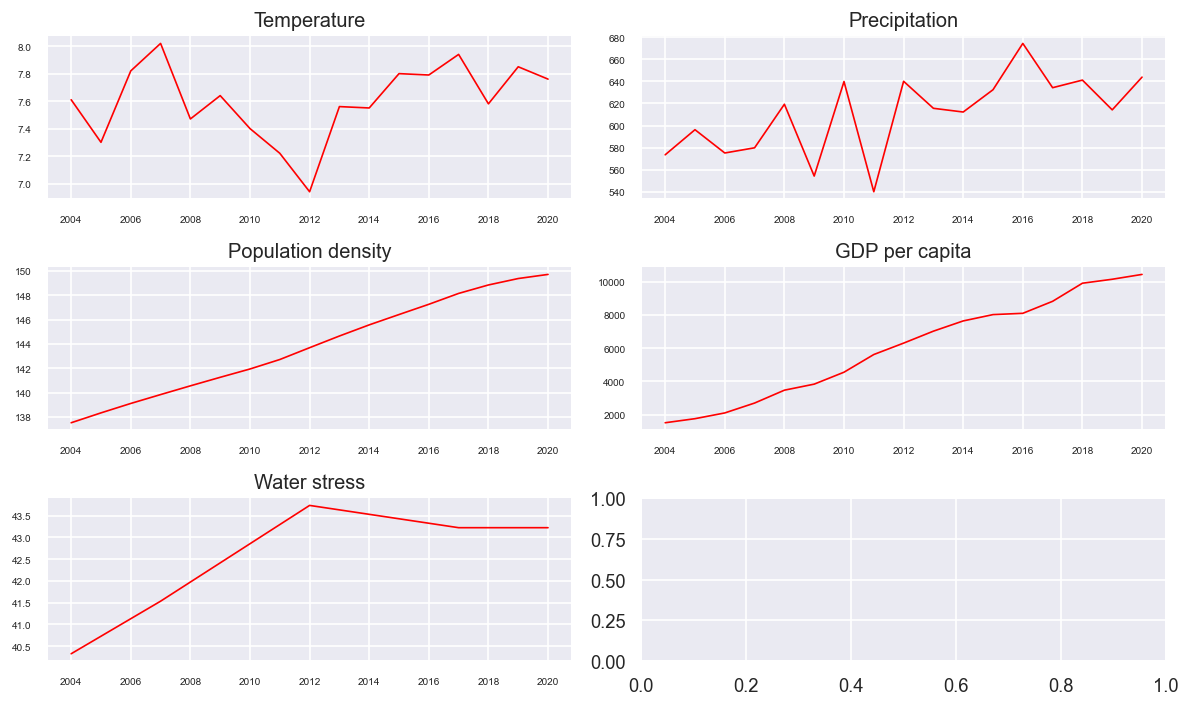

In [426]:
plot_vars(ts)

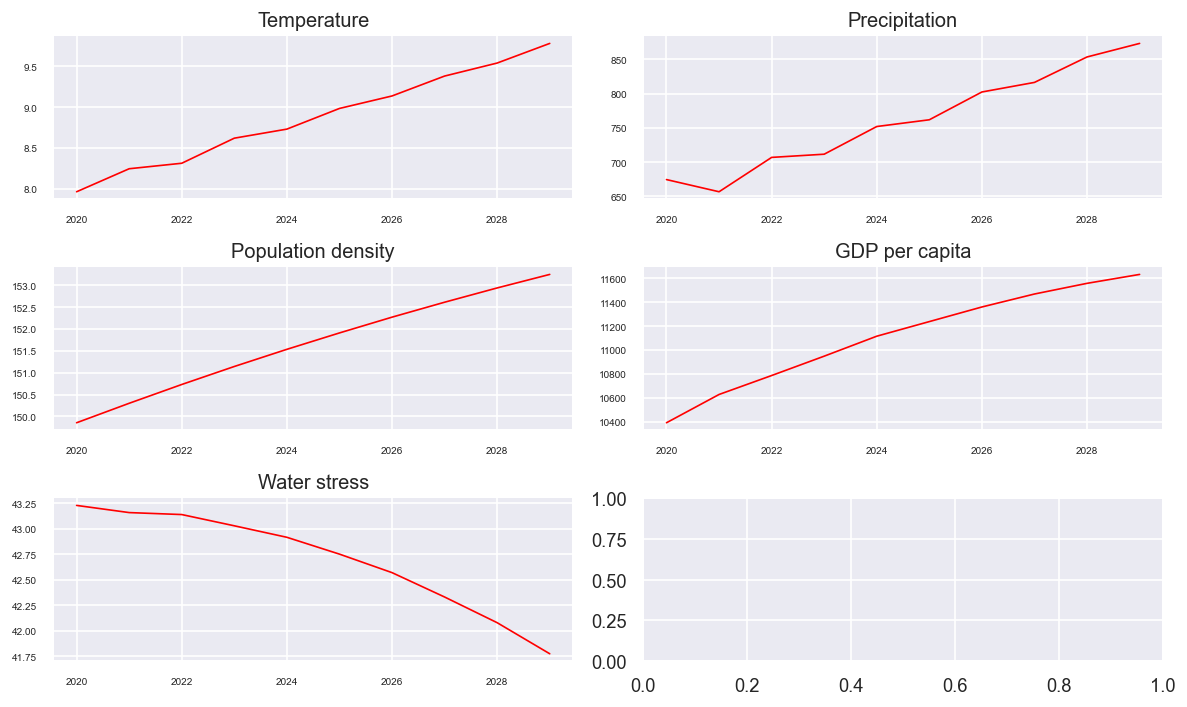

In [427]:
plot_vars(ts_results)